# TwoStageModel: Spatial Equity Diagnostic

This notebook demonstrates the complete workflow for diagnosing spatial accuracy patterns using `TwoStageModel`.

## Two Experiment Modes

| Mode | Description | Use Case |
|------|-------------|----------|
| **Single Sufficiency** | One fixed sample size | Quick analysis, production models |
| **Multi Sufficiency** | Multiple sample sizes (5K, 20K, 100K) | Studying how accuracy changes with data volume |



## Overview

1. **Configuration** - Set data path, features, target
2. **Sufficiency Levels** - Single or multi-sufficiency experiment
3. **Data Density** - Calculate station density
4. **Data Split** - Site-wise cross-validation
5. **Feature Engineering** - Spatial/temporal harmonics (customizable!)
6. **Train Model** - Baseline ML model
7. **TwoStageModel** - Fit & diagnose
8. **Predict** - Accuracy at new locations


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys
from pathlib import Path
%load_ext autoreload
%autoreload 2

# Add geoequity to path (for running without pip install)
# This allows running directly from source code
GEOEQUITY_ROOT = Path("..").resolve()
if str(GEOEQUITY_ROOT) not in sys.path:
    sys.path.insert(0, str(GEOEQUITY_ROOT))

# Import geoequity modules
from two_stage import TwoStageModel
from data import split_test_train, calculate_density, simple_feature_engineering

print("geoequity imported successfully!")
print(f"Source path: {GEOEQUITY_ROOT}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
geoequity imported successfully!
Source path: D:\OneDrive\Code\Ozone_Reconstruction\Submission_Code\geoequity


## 1. Configuration & Load Data

**Modify the configuration below to use your own dataset!**

### Required columns:
- `longitude`, `latitude`: Spatial coordinates (float)
- `time`: Timestamp (datetime)
- Target column (e.g., `o3`): Observed values (float)

### Configuration variables:
| Variable | Description |
|----------|-------------|
| `DATA_PATH` | Path to your pickle file |
| `TARGET_COL` | Column name for target values |
| `FEATURE_COLS` | List of feature column names |
| `PRED_COL` | Name for prediction column |

The example uses ozone observations from June-September 2019 (3.5M samples).


In [90]:
 
# ============================================================
# 🎯 CONFIGURATION - Modify these settings for your dataset
# ============================================================

# Experiment mode
EXPERIMENT_MODE = 'single'  # Options: 'single' or 'multi'
# - 'single': Use full dataset (one sufficiency level)
# - 'multi':  Create 3 sufficiency levels: 5000, 20000, 100000

# Data path
DATA_PATH = 'data/df_example.pkl'  # Replace with your data file

# Target column (what you want to predict)
TARGET_COL = 'Ozone'

# Feature columns (predictors for baseline model)
FEATURE_COLS = ['time','TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m', 'sp', 'WS10', 
 'population', 'no2', 'DSR',"strd", "r_1000", "lai_hv", "pev", "ssro","t_975","t_925","tp","tsn","stl1",'latitude','longitude']

# Prediction column name (will be created by baseline model)
PRED_COL = 'predicted_linear'


In [91]:

# ============================================================
# Load data
# ============================================================
df = pd.read_pickle(DATA_PATH)
df["time"]=pd.to_datetime(df["time"])
for col in df.select_dtypes(include=["float64", "int64"]).columns:
    df[col] = df[col].astype("float32")
    
# Convert to float32 for memory efficiency
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].astype('float32')

# Validate required columns
required_cols = ['longitude', 'latitude', 'time', TARGET_COL]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Validate feature columns
available_features = [c for c in FEATURE_COLS if c in df.columns]
if len(available_features) < len(FEATURE_COLS):
    print(f"⚠️ Some features not found, using: {available_features}")
    FEATURE_COLS = available_features

n_locations = df.groupby(['longitude', 'latitude']).ngroup().nunique()
print(f"Loaded {len(df):,} samples from {n_locations:,} unique locations")
print(f"Time range: {df['time'].min()} to {df['time'].max()}")
print(f"\nTarget: {TARGET_COL}")
print(f"Features: {FEATURE_COLS}")
df.head()

Loaded 3,520,452 samples from 1,302 unique locations
Time range: 2019-06-01 00:00:00 to 2019-09-29 23:00:00

Target: Ozone
Features: ['time', 'TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m', 'sp', 'WS10', 'population', 'no2', 'DSR', 'strd', 'r_1000', 'lai_hv', 'pev', 'ssro', 't_975', 't_925', 'tp', 'tsn', 'stl1', 'latitude', 'longitude']


,time,r_1000,sp,stl1,blh,t_975,population,tsn,t2m,DSR,...,tp,no2,strd,OMI_ozone,Unnamed: 0,site_number,sampling_height,Ozone,latitude,longitude
4235938,2019-06-01 00:00:00,40.118874,92562.484375,294.035126,12.997529,301.286194,0.0,273.159912,294.071289,323.755768,...,0.000003,0.000012,30846750.0,0.000007,3521.0,1.0,2.75,56.968533,35.0,33.0
4235939,2019-06-01 01:00:00,40.820999,92550.921875,293.471710,11.205620,301.448181,0.0,273.159668,293.956604,323.060455,...,0.000000,0.000013,1177312.0,0.000007,3522.0,1.0,2.75,60.438416,35.0,33.0
4235940,2019-06-01 02:00:00,39.497925,92548.421875,292.972778,13.652981,301.544983,0.0,273.159668,293.848602,322.365143,...,0.000000,0.000013,2347693.5,0.000007,3523.0,1.0,2.75,59.958427,35.0,33.0
4235941,2019-06-01 03:00:00,37.452812,92548.109375,292.592804,19.237371,301.245117,0.0,273.161133,294.628082,321.669861,...,0.000000,0.000013,3514501.0,0.000006,3524.0,1.0,2.75,56.148556,35.0,33.0
4235942,2019-06-01 04:00:00,36.479145,92570.617188,293.640198,35.947742,300.535797,0.0,273.159668,295.702423,320.974548,...,0.000000,0.000014,4685279.5,0.000006,3525.0,1.0,2.75,56.758514,35.0,33.0


### 1.1 Create Sufficiency Levels

**Single mode**: Use full dataset as one sufficiency level (100k).

**Multi mode**: Sample data at 3 sizes (5K, 20K, 100K) to study how accuracy varies with data volume.

In [92]:
# ============================================================
# Create sufficiency levels based on experiment mode
# ============================================================
if EXPERIMENT_MODE == 'multi':
    # Multi-sufficiency: sample at 3 different sizes
    SUFFICIENCY_LEVELS = [5000, 20000, 100000]
    
    np.random.seed(42)
    df_list = []
    for suff in SUFFICIENCY_LEVELS:
        if len(df) >= suff:
            df_sampled = df.sample(n=suff, random_state=42).copy()
        else:
            df_sampled = df.copy()
        df_sampled['sufficiency'] = suff
        df_list.append(df_sampled)
    
    df = pd.concat(df_list, ignore_index=True)
    print(f"Multi-sufficiency mode: {SUFFICIENCY_LEVELS}")
    print(f"Total samples: {len(df):,}")
    print(f"\nSamples per sufficiency level:")
    print(df['sufficiency'].value_counts().sort_index())
    
else:
    # Single sufficiency: use 100k (or as many samples as available if less)
    n_suff = min(100000, len(df))
    if len(df) > n_suff:
        df = df.sample(n=n_suff, random_state=42).copy()
    df['sufficiency'] = 100000
    print(f"Single sufficiency mode: using {len(df):,} samples (target 100,000)")


Single sufficiency mode: using 100,000 samples (target 100,000)


## 2. Calculate Data Density

Calculate data density for each location. Higher density = more nearby observation stations.


Calculating density (r=500km):   0%|          | 0/1302 [00:00<?, ?it/s]

Density range: 1.81e-06 - 2.11e-04


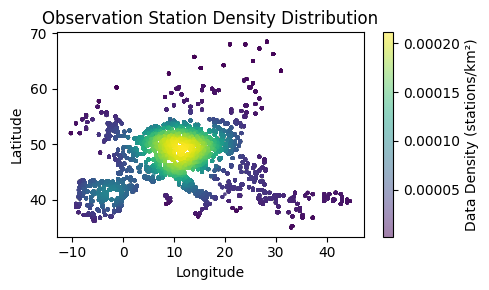

In [93]:
# Calculate density with 500km radius
# In real case, you should calculate the density based on training stations
df = calculate_density(df, radius=500)

print(f"Density range: {df['density'].min():.2e} - {df['density'].max():.2e}")

# Visualize density distribution
fig, ax = plt.subplots(figsize=(5, 3))
scatter = ax.scatter(df['longitude'], df['latitude'], c=df['density'], 
                     cmap='viridis', s=3, alpha=0.5)
plt.colorbar(scatter, label='Data Density (stations/km²)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Observation Station Density Distribution')
plt.tight_layout()
plt.show()


## 3. Split Data (Site-wise Cross-Validation)

Use site-wise split to avoid data leakage - same station's observations stay in same set.


In [94]:
# Site-wise split using split_test_train
# flag='Site' ensures same station's observations stay in same set

if EXPERIMENT_MODE == 'multi':
    # Multi: split each sufficiency level separately
    split_results = {}  # {sufficiency: (train_idx, test_idx)}
    for suff in df['sufficiency'].unique():
        df_suff = df[df['sufficiency'] == suff].copy()
        _, _, train_idx_s, test_idx_s, _ = split_test_train(
            df_suff, split=0.2, flag='Site', seed=42, verbose=0
        )
        split_results[suff] = (train_idx_s, test_idx_s)
        print(f"Sufficiency {suff:,}: Train {len(train_idx_s)}, Test {len(test_idx_s)}")
else:
    # Single: original logic
    train_sites, test_sites, train_idx, test_idx, df = split_test_train(
        df, split=0.2, flag='Site', seed=42, verbose=1
    )
    print(f"\nTrain: {len(train_idx)} samples, Test: {len(test_idx)} samples")


Using flag: Site
Selected Site Count: 260, (19.97%)
Selected DataRow Count: 19765, (19.77%)
Training Site Count: 1042, (80.03%)
Training DataRow Count: 80235, (80.23%)

Train: 80235 samples, Test: 19765 samples


## 4. Feature Engineering & Train Model

### Feature Engineering Options

**You can use your own feature engineering method!** The provided `simple_feature_engineering` is just an example.

| Step | Description |
|------|-------------|
| Fill NA | Replace missing values with median |
| Temporal Harmonics | Add T1, T2, T3 (Fourier features for seasonality) |
| Spatial Harmonics | Add S1, S2, S3 (spherical harmonics from lon/lat) |
| Standardize | Zero mean, unit variance scaling |

```python
# Option A: Use provided feature engineering
X, y, feature_names = simple_feature_engineering(df, FEATURE_COLS, TARGET_COL)

# Option B: Use your own method
X = your_custom_preprocessing(df[FEATURE_COLS])
y = df[TARGET_COL]
```


In [95]:
# ============================================================
# Feature Engineering & Train - per sufficiency level if multi
# ============================================================
df[PRED_COL] = np.nan  # Initialize prediction column

if EXPERIMENT_MODE == 'multi':
    # Multi: train each sufficiency level separately
    for suff in df['sufficiency'].unique():
        print(f"\n{'='*50}")
        print(f"Training for Sufficiency = {suff:,}")
        print(f"{'='*50}")
        
        # Get data for this sufficiency
        df_suff = df[df['sufficiency'] == suff]
        train_idx_s, test_idx_s = split_results[suff]
        
        # Feature engineering
        X_suff, y_suff, _ = simple_feature_engineering(
            df_suff, FEATURE_COLS, TARGET_COL,
            add_spatial_harmonics=True, add_temporal_harmonics=True,
            standardize=True, verbose=False
        )
        
        X_train = X_suff.loc[train_idx_s]
        y_train = y_suff.loc[train_idx_s]
        X_test = X_suff.loc[test_idx_s]
        y_test = y_suff.loc[test_idx_s]
        
        # Train model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Add predictions back to df
        df.loc[train_idx_s, PRED_COL] = model.predict(X_train)
        df.loc[test_idx_s, PRED_COL] = model.predict(X_test)
        
        # Evaluate
        test_r2 = r2_score(y_test, df.loc[test_idx_s, PRED_COL])
        print(f"Test R²: {test_r2:.4f}")
    
    # Store all test indices for TwoStageModel
    all_test_idx = []
    for suff in df['sufficiency'].unique():
        all_test_idx.extend(split_results[suff][1])
    test_idx = all_test_idx

else:
    # Single: original logic
    X, y, FINAL_FEATURES = simple_feature_engineering(
        df, FEATURE_COLS, TARGET_COL,
        add_spatial_harmonics=True, add_temporal_harmonics=True, standardize=True
    )
    
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    
    print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    df.loc[train_idx, PRED_COL] = model.predict(X_train)
    df.loc[test_idx, PRED_COL] = model.predict(X_test)
    
    train_r2 = r2_score(y_train, df.loc[train_idx, PRED_COL])
    test_r2 = r2_score(y_test, df.loc[test_idx, PRED_COL])
    
    print(f"\n{'='*50}")
    print(f"Model Evaluation")
    print(f"{'='*50}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²:  {test_r2:.4f}")


Feature Engineering Pipeline: fill NA → temporal harmonics → spatial harmonics → standardize
  ✓ Added temporal harmonics: T1, T2, T3, month, hour
  ✓ Added spatial harmonics: S1, S2, S3 (replaced lon/lat)
  ✓ Standardized all features

Final features (28): ['TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m']...

Train shape: (80235, 28), Test shape: (19765, 28)

Model Evaluation
Train R²: 0.4953
Test R²:  0.4897


## 5. Fit TwoStageModel

Analyze how accuracy varies with data density and location.


In [96]:
# ============================================================
# Prepare data for TwoStageModel
# ============================================================
from two_stage.model import find_bins_intervals

# Add 'observed' column (required by TwoStageModel)
df['observed'] = df[TARGET_COL]

# Extract model name from prediction column (e.g., 'predicted_linear' -> 'linear')
MODEL_NAME = PRED_COL.replace('predicted_', '')

# Create bins intervals for density and sufficiency
bins_intervals = find_bins_intervals(df, density_bins=7)
print(f"Created bins for {len(bins_intervals[1])} sufficiency levels")

# ============================================================
# Initialize and fit TwoStageModel
# ============================================================
ts_model = TwoStageModel(
    spline=7,           # GAM spline knots
    lam=0.5,            # GAM regularization
    resolution=[30, 30] # Spatial aggregation grid
)

# Fit model using test data to analyze accuracy patterns
# This learns how accuracy varies with density and location
# In real case, you should use the density based on training stations
ts_model.fit(
    df_train_raw=df.loc[test_idx],
    model_name=MODEL_NAME,
    bins_intervals=bins_intervals,
    split_by='grid'
)

print(f"\n{'='*50}")
print(f"TwoStageModel Training Complete!")
print(f"{'='*50}")
print(f"Model: {PRED_COL} → {TARGET_COL}")
print(f"Stage 1 R² (GAM on density): {ts_model.stage1_score:.4f}")
print(f"Stage 2 R² (GAM+SVM spatial): {ts_model.stage2_score:.4f}")
print(f"Mode: {'Single' if ts_model.single_sufficiency else 'Multi'} Sufficiency")


Created bins for 1 sufficiency levels

TwoStageModel Training Complete!
Model: predicted_linear → Ozone
Stage 1 R² (GAM on density): 0.9872
Stage 2 R² (GAM+SVM spatial): 0.6429
Mode: Single Sufficiency


## 6. Predict Accuracy for New Locations

Use the fitted model to predict expected accuracy (R²) at any location.

**Key Points:**
- `density` must be calculated per-pixel (based on distance to training stations)
- For multi-sufficiency mode, we use the first sufficiency level as default
- Predictions use the new API: `predict(longitude, latitude, density, sufficiency)`


Dense area (5°E, 50°N):  R² = 0.6148
Sparse area (30°E, 55°N): R² = 0.5680
Equity Gap: 0.0468


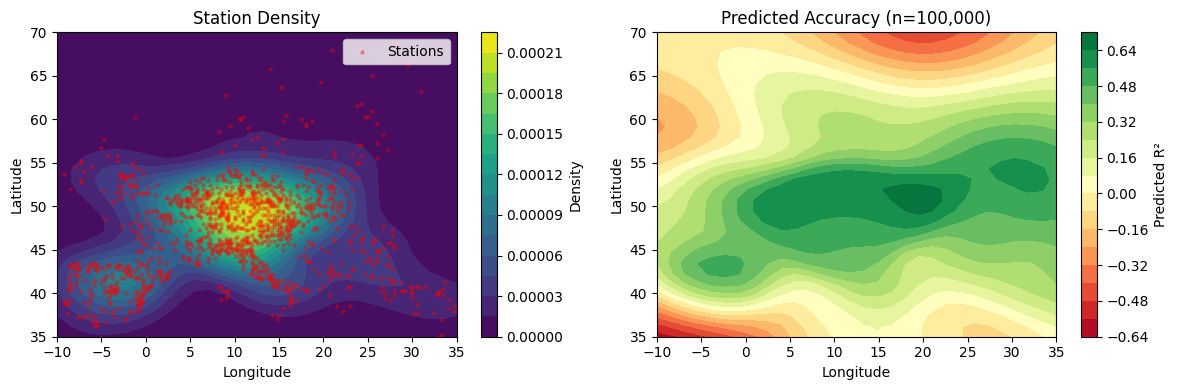

In [97]:
# Your network stations and sample size
stations = df.drop_duplicates(subset=['longitude', 'latitude'])
sufficiency = df['sufficiency'].unique()[0]

# Import visualization tools
from two_stage import plot_predicted_accuracy_map, predict_at_locations

# Example 1: Predict at specific locations
r2_dense, _ = predict_at_locations(ts_model, 5.0, 50.0, stations['longitude'], stations['latitude'], sufficiency)
r2_sparse, _ = predict_at_locations(ts_model, 30.0, 55.0, stations['longitude'], stations['latitude'], sufficiency)
print(f"Dense area (5°E, 50°N):  R² = {r2_dense[0]:.4f}")
print(f"Sparse area (30°E, 55°N): R² = {r2_sparse[0]:.4f}")
print(f"Equity Gap: {float(r2_dense[0] - r2_sparse[0]):.4f}")

# Example 2: Plot predicted accuracy map
fig, axes = plot_predicted_accuracy_map(
    ts_model, stations['longitude'], stations['latitude'], sufficiency,
    lon_range=(-10, 35), lat_range=(35, 70), grid_size=30
)
plt.show()


## 7. Generate Diagnostic Report

Generate diagnostic plots and text report for model analysis.


✓ Stage 1 diagram saved to: diagnostics/stage1_gam.png


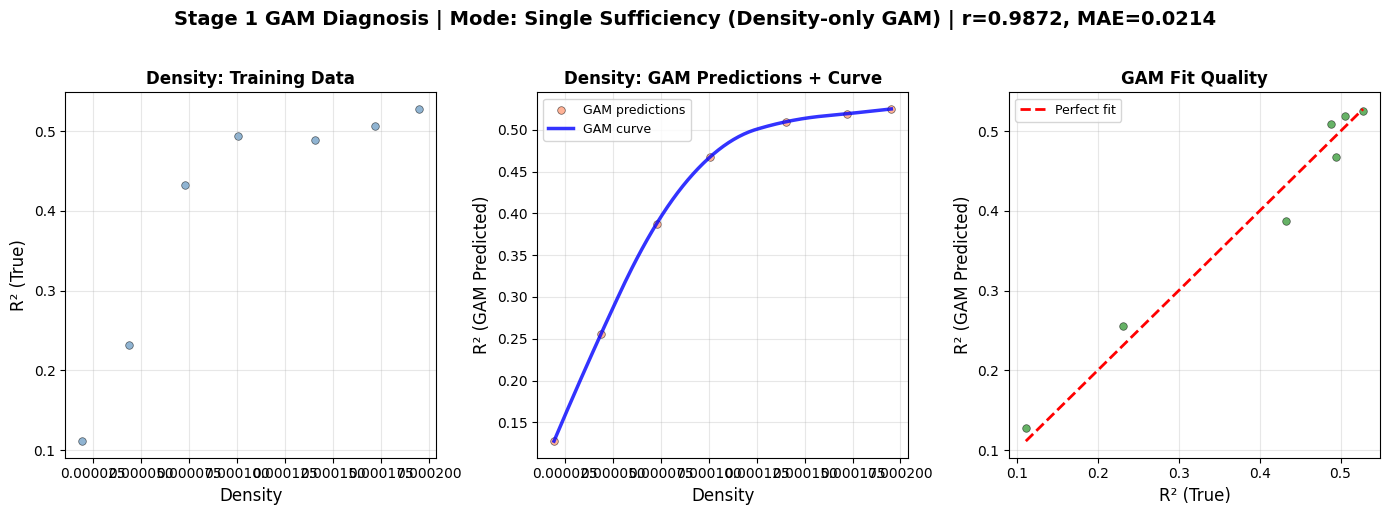

✓ Stage 2 diagram saved to: diagnostics/stage2_svm.png


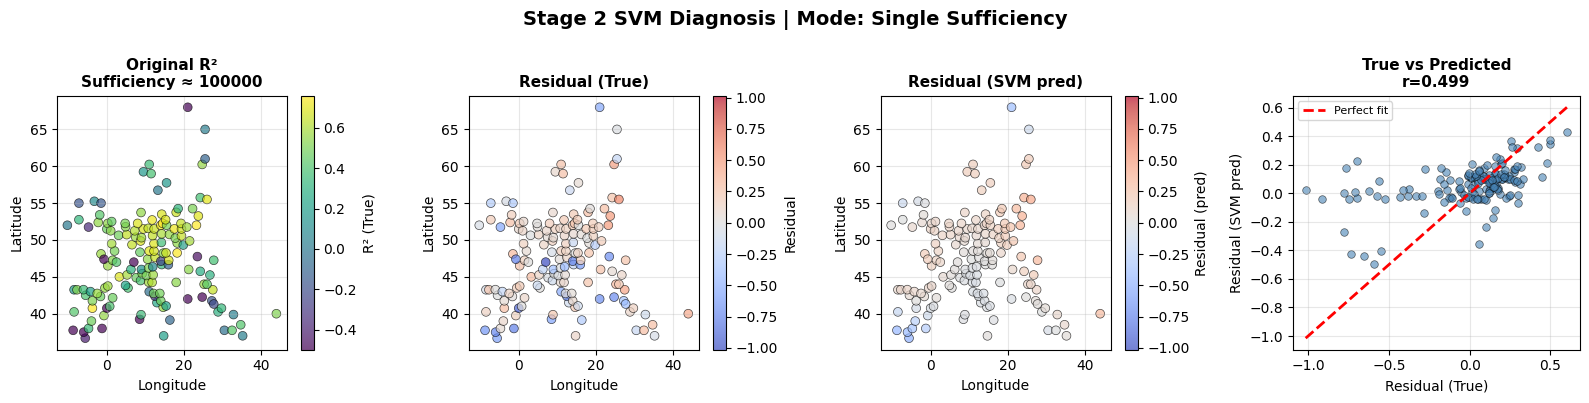

✓ Diagnosis saved to: diagnostics//

Diagnostic files saved:
  - diagnostics//stage1_gam.png
  - diagnostics//stage2_svm.png
  - diagnostics//diagnosis.txt

========== TwoStageModel Diagnosis ==========

Mode: Single Sufficiency

Stage 1 (Monotonic GAM) - Density/Sampling Effect:
  - r = 0.9872, MAE = 0.0214
  - Training samples: 7
  - Spline knots: 7, Lambda: 0.5

Stage 2 (SVM) - Spatial Residual:
  - r = 0.4986, MAE = 0.1830
  - Training samples: 152
  - Spatial features: ['longitude', 'latitude']
  - Resolution: [30, 30]

Total (GAM + SVM):
  - r = 0.6429, MAE = 0.1830

Key Insights:
  1. Density effect captured in Stage 1 (r=0.987)
     → Predicts accuracy variation from sampling density
  2. Spatial pattern captured in Stage 2 (r=0.499)
     → Predicts location-specific residuals
  3. Prediction ability:
     → Unseen sampling density: r=0.987 (Stage 1)
     → Unseen locations: r=0.643 (Total)



Diagnostic files saved:
  - diagnostics/stage1_gam.png
  - diagnostics/stage2_svm.png

In [98]:
# Generate diagnostics
diagnosis = ts_model.diagnose(save_dir='diagnostics/', show=True)

print("\nDiagnostic files saved:")
print("  - diagnostics/stage1_gam.png")
print("  - diagnostics/stage2_svm.png")
print("  - diagnostics/diagnosis.txt")


## Summary

### Core Concepts

| Term | Definition |
|------|------------|
| **Sufficiency** | Training sample size (e.g., 5K, 20K, 100K observations) |
| **Density** | Observation station density at a location (stations/km² within radius) |

### Workflow

| Step | Function | Description |
|------|----------|-------------|
| 1 | `calculate_density()` | Calculate station density for each location |
| 2 | `split_test_train()` | Site-wise split avoiding data leakage |
| 3 | `TwoStageModel.fit()` | Learn density→accuracy + spatial patterns |
| 4 | `TwoStageModel.predict()` | Predict accuracy at any location |
| 5 | `TwoStageModel.diagnose()` | Generate diagnostic plots & report |

### Key Insight

Machine learning models trained on geospatial data exhibit **spatial inequity**: prediction accuracy varies systematically across space. This inequity arises from two sources:

1. **Sampling Density Effect** (Stage 1): Regions with denser observation networks provide more training data, leading to higher local accuracy. The monotonic GAM captures this density→accuracy relationship.

2. **Spatial Residual Effect** (Stage 2): Even after accounting for density, some locations have systematically higher/lower accuracy due to local data quality, terrain complexity, or other spatial factors. The SVM captures these location-specific patterns.

**TwoStageModel** quantifies and predicts this spatial inequity, enabling:
- Fair assessment of model performance across regions
- Identification of under-served areas needing more observations
- Uncertainty quantification for downstream applications
